In [145]:
# required library : numpy / matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### NMS alg

In [146]:
def nonmaximum_suppression_cpu(boxes, pred_conf, iou_threshold=0.5, debug=False):
    """
    boxes (tf.Tensor): [number_of_bboxes, 0:4]. 0:4 가 의미하는 바는 [y1, x1, y2, x2] 입니다.
    pred_conf (tf.Tensor): [number_of_bboxes, number_of_class], 각 원소가 나타내는 것은 각 class 일 confidence 입니다.
    """
    
    if type(boxes) != np.ndarray:
        boxes = boxes.numpy()

    """
    boxes = np.reshape(boxes, [boxes.shape[0], -1, 1, 4])
    boxes = np.squeeze(boxes) # [number_of_bbox, 4]
    """
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return np.array([]), np.array([]), np.array([]), np.array(0)

    if type(boxes) != np.ndarray:
        pred_conf = pred_conf.numpy()
    
    """
    pred_conf = np.squeeze(pred_conf)
    """
    
    cls_max_conf = pred_conf.argmax(axis=1)
    
    if debug:
        print('\n{}-shape: {}\n{}\nexample: {}\n'.format('boxes', boxes.shape, boxes, boxes[0]))        
        print('\n{}-shape: {}\n{}\nexample: {}\n'.format('pred_conf', pred_conf.shape, pred_conf, pred_conf[0]))
        print('\n{}-shape: {}\n{}\nexample: {}\n'.format('cls_max_conf', cls_max_conf.shape, cls_max_conf, cls_max_conf[0]))
    
    
    # NMS without class
    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    # [y1, x1, y2, x2] (tensorflow)
    y1 = boxes[:,0]
    x1 = boxes[:,1]
    y2 = boxes[:,2]
    x2 = boxes[:,3]
    
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2-x1 + 1) * (y2-y1 + 1)
    y2_sorted_idx_li = np.argsort(y2)

    while len(y2_sorted_idx_li):
        
        if debug :
            print('\n\n ---- iteration start ----- ::: \n{}\n{}\n'.format('y2_sorted_idx_li', y2_sorted_idx_li))        
            
        maximum_y2_idx = y2_sorted_idx_li[len(y2_sorted_idx_li)-1] 

        # y2[maximum_y2_idx] 는 '탐색 완료되지 않은' 애들 중에서 가장 큰 y2 바운딩 박스의 값.
        pick.append(maximum_y2_idx)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box

        # 아래 네 줄의 코드를 이해하기 위해서 잘 상상을 해 보자.
        # y2 (특정 bounding box 의 하단 y 좌표값) 보다 작은 y 값을 가지는 모든 bounding box 들을 생각해 보자.
        # 이 while loop 는 항상 가장 큰 y2 의 좌표가 포함된 bounding box 만 골라내고, while loop 한 번을 돌 때마다,
        # 자신의 좌상단 좌표의 x,y 보다 작은 bounding box 들의 좌상단 x,y 는 자신의 x,y 로 만들고
        # 자신의 우하단 좌표의 x,y 보다 큰 bounding box 들의 우하단 x,y 도 자신의 x,y 로 만든다.
        # 둘 모두가 아닌 것에 대해서만, 다른 bounding box 의 x,y 를 가만히 놓아두는데, 이것은 결국 따지고 보면,
        # 자신의 좌상단 좌표와 우하단 좌표가 만드는 bounding box 내부의 좌표이다.
        # 위와 같이 '자신의 좌표로 만드는' 것과 '가만히 두는 것' 을 처리한 결과를 벡터 xx1, yy1, xx2, yy2 에 담는다.
        xx1 = np.maximum(x1[maximum_y2_idx], x1[y2_sorted_idx_li[:maximum_y2_idx]])
        yy1 = np.maximum(y1[maximum_y2_idx], y1[y2_sorted_idx_li[:maximum_y2_idx]])
        xx2 = np.minimum(x2[maximum_y2_idx], x2[y2_sorted_idx_li[:maximum_y2_idx]])
        yy2 = np.minimum(y2[maximum_y2_idx], y2[y2_sorted_idx_li[:maximum_y2_idx]])
        
        # compute the ratio of overlap
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        intersection = w * h
        
        iou = intersection / (areas[maximum_y2_idx] + areas[y2_sorted_idx_li[:maximum_y2_idx]] - intersection)

        if debug :
            print('\n{}\n{}\n'.format('intersection', intersection))
            print('\n{}\n{}\n'.format('iou', iou))


            """ for debugging
            print(iou>iou_threshold)
            print(cls_max_conf[y2_sorted_idx_li[:maximum_y2_idx]] == cls_max_conf[maximum_y2_idx])
            print(np.where
                  (
                    (iou>iou_threshold) & (cls_max_conf[y2_sorted_idx_li[:maximum_y2_idx]] == cls_max_conf[maximum_y2_idx])
                  )
                 )
            print([len(y2_sorted_idx_li)-1])
            """

            print('\nconcatenation output :\n{}\n'.format(
                    np.concatenate(
                        [
                            [len(y2_sorted_idx_li)-1], 
                            np.where(
                                (iou>iou_threshold) & (cls_max_conf[y2_sorted_idx_li[:maximum_y2_idx]] == cls_max_conf[maximum_y2_idx]) )[0]
                        ]
                    )
                ))
            print('\nremoved!\n{}\n'.format(
                    y2_sorted_idx_li[np.concatenate(
                            (
                                 [len(y2_sorted_idx_li)-1], 
                                 np.where( (iou>iou_threshold)&(cls_max_conf[y2_sorted_idx_li[:maximum_y2_idx]] == cls_max_conf[maximum_y2_idx]) )[0]
                            )
                        )]
                ))

                                   
        # delete all indexes from the index list that have
        y2_sorted_idx_li = np.delete(y2_sorted_idx_li, 
                    np.concatenate(
                        ([len(y2_sorted_idx_li)-1], np.where((iou>iou_threshold) & (cls_max_conf[y2_sorted_idx_li[:maximum_y2_idx]] == cls_max_conf[maximum_y2_idx]))[0])
                    )
                )

    if debug :
        print('\n\n ---- iteration end ----- :::')
        
        print('picked box - shape : {}\n\
               picked boxes confidence - shape : {} - value : {}\n\
               picked boxes classes - shape : {} - value : {}\n\
               number of boxes - shape : {} - value - {}\n'.format(
                   boxes[pick].shape,
                   pred_conf[pick].shape, np.round(pred_conf[pick], 2),
                   cls_max_conf[pick].shape, cls_max_conf[pick],
                   np.array(len(boxes[pick])).shape, len(boxes[pick])))
        
    return boxes[pick].astype('int'), pred_conf[pick], cls_max_conf[pick].astype('int'), np.array(len(boxes[pick]))
    # boxes, scores, classes, number of bounding box
    # numpy, numpy, numpy, numpy

### define custom input data for test

In [149]:
# boxes (tf.Tensor): [number_of_bboxes, 0:4]. 0:4 가 의미하는 바는 [y1, x1, y2, x2] 입니다.
boxes = np.array([
    [10, 10, 100, 100], # yx yx
    [15, 5, 120, 110], # yx yx
    [5, 15, 130, 90], # yx yx
    [60, 60, 150, 160], # yx yx
    [160, 130, 220, 220],
    [190, 200, 230, 240],
    [170, 120, 240, 195],
    [100, 140, 250, 210],
])

# pred_conf (tf.Tensor): [number_of_bboxes, number_of_class], 각 원소가 나타내는 것은 각 class 일 confidence 입니다.
pred_conf = np.array([
    [0.8, 0.2, 0, 0, 0], # 0
    [0.8, 0.2, 0, 0, 0], # 0
    [0, 0, 0, 0, 1], # 5
    [0, 0.9, 0.1, 0, 0], # 1
    [0, 0, 0, 1, 0], # 3
    [0.2, 0.2, 0, 0.6, 0], # 3
    [0.2, 0.2, 0, 0.6, 0], # 3
    [0.2, 0.2, 0, 0.1, 0.5], # 4
])

print(boxes.shape)
print(pred_conf.shape)

(8, 4)
(8, 5)


### draw


pred_conf
[[0.8 0.2 0.  0.  0. ]
 [0.8 0.2 0.  0.  0. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.9 0.1 0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.2 0.2 0.  0.6 0. ]
 [0.2 0.2 0.  0.6 0. ]
 [0.2 0.2 0.  0.1 0.5]]


cls_max_conf
[0 0 4 1 3 3 3 4]



 ---- iteration start ----- ::: 
y2_sorted_idx_li
[0 1 2 3 4 5 6 7]


intersection
[   0    0    0 1071 4331  451 3976]


iou
[0.         0.         0.         0.05684412 0.36269994 0.03773743
 0.32748538]


concatenation output :
[7]


removed!
[7]



 ---- iteration start ----- ::: 
y2_sorted_idx_li
[0 1 2 3 4 5 6]


intersection
[   0    0    0    0 3366    0]


iou
[0.         0.         0.         0.         0.44400475 0.        ]


concatenation output :
[6 4]


removed!
[6 4]



 ---- iteration start ----- ::: 
y2_sorted_idx_li
[0 1 2 3 5]


intersection
[   0    0    0    0 1681]


iou
[0. 0. 0. 0. 1.]


concatenation output :
[4 4]


removed!
[5 5]



 ---- iteration start ----- ::: 
y2_sorted_idx_li
[0 1 2 3]


intersection
[1681 3111 2201]


iou
[

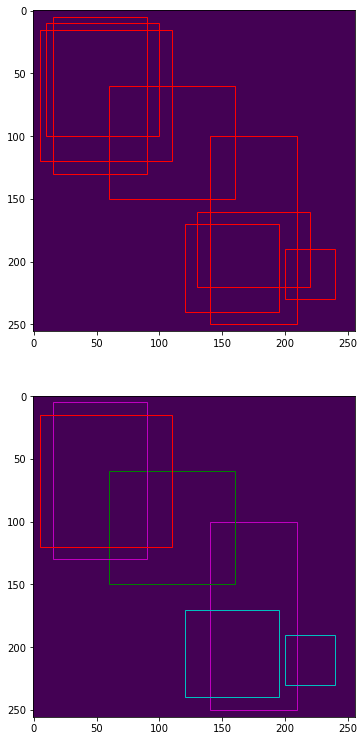

In [150]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.figure(figsize = [8, 13])
img = np.zeros([256, 256])
ax = plt.subplot(2,1,1)

# define color map
num_of_cls = pred_conf.shape[-1]
edgecolor = [
    'r',
    'g',
    'b',
    'c',
    'm',
]
assert len(edgecolor) == num_of_cls, '색상을 {} 개 정의했지만, 클래스의 종류는 {} 개 입니다.'.format(len(edgecolor), num_of_cls) 

# draw1
for box in boxes:    
    rect = patches.Rectangle((box[1], box[0]), box[3]-box[1], box[2]-box[0], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.imshow(img)


# NMS
final_boxes, pred_cls, pred_conf = nonmaximum_suppression_cpu(boxes, pred_conf, iou_threshold=0.3, debug=True)
print('\n{}\n{}\n'.format('final_boxes', final_boxes))
print('\n{}\n{}\n'.format('pred_cls', pred_cls))
print('\n{}\n{}\n'.format('pred_conf', pred_conf))

ax2 = plt.subplot(2,1,2)

# draw2
for i, box in enumerate(final_boxes):
    rect = patches.Rectangle((box[1], box[0]), box[3]-box[1], box[2]-box[0], edgecolor=edgecolor[pred_cls[i]], facecolor='none')
    ax2.add_patch(rect)
plt.imshow(img)